# Modelling!

I will now dive into modelling the WNV cases using the datasets created in the previous Preprocessing notebook.  Hopefully I can improve upon the Logistic Regression model (especially the recall score) at the end of that notebook. 

Steps:
1.  Import data sets and modeling packages from sklearn. 
2. Try different models, tune hyperparameters and evaluate each.  
    1. Random Forest
    2. Gradient Boost
    3. XG Boost
    4. Support Vector Classifier
    5. Revist Logistic regression
3. Select the best model and output the model. Selection will be based on:
    - Test AUC score
    - Test Recall score

Import pandas numpy and all of the datasets.

In [1]:
random_seed = 27

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
y_train = pd.read_csv('y_train.csv',index_col=0).to_numpy().reshape(-1,)
y_test = pd.read_csv('y_test.csv',index_col=0).to_numpy().reshape(-1,)

### Note these are already standard scaled
X_train = pd.read_csv('X_train.csv',index_col=0).to_numpy()
X_test = pd.read_csv('X_test.csv',index_col=0).to_numpy()

#X_train_pca95 = pd.read_csv('X_train_pca95.csv',index_col=0).to_numpy()
#X_test_pca95 = pd.read_csv('X_test_pca95.csv',index_col=0).to_numpy()

#X_train_nmf = pd.read_csv('X_train_nmf.csv',index_col=0).to_numpy()
#X_test_nmf = pd.read_csv('X_test_nmf.csv',index_col=0).to_numpy()

Next a couple functions that will help in evaluating model performance and collecting the model metrics to help with selecting a model.

In [4]:
def Model_Eval(estimator,X_train,X_test,y_train,y_test):
    from sklearn.metrics import plot_confusion_matrix,precision_score,\
                                recall_score, plot_roc_curve
    import matplotlib.pyplot as plt
    
    fig,ax = plt.subplots(figsize=(5,5))
    plot_roc_curve(estimator,X_train,y_train,ax=ax,name='Train')
    plot_roc_curve(estimator,X_test,y_test,ax=ax,name='Test')
    plt.title('ROC curve')
    plt.show()

    fig,ax = plt.subplots(1,2,figsize=(10,5),tight_layout=True)
    plot_confusion_matrix(estimator,X_train,y_train,values_format='.4g',ax=ax[0],cmap='Blues')
    plot_confusion_matrix(estimator,X_test,y_test,values_format='.4g',ax=ax[1],cmap='Oranges')
    ax[0].set_title('Train')
    ax[1].set_title('Test')
    plt.show()

    ### Training
    print('Train Precision {:.3f}'.format(precision_score(\
                              y_train,estimator.predict(X_train))))
    print('Train Recall    {:.3f}'.format(recall_score(\
                               y_train,estimator.predict(X_train))))
    print()
    ### Testing
    print('Test Precision  {:.3f}'.format(precision_score(\
                              y_test,estimator.predict(X_test))))
    print('Test Recall     {:.3f}'.format(recall_score(\
                               y_test,estimator.predict(X_test))))

Initialize dataframe for collecting model performance

In [5]:
df_cols = ['Model','Train_AUC','Test_AUC','Train_prec','Train_recal','Test_prec','Test_recal']
scores_df=pd.DataFrame(columns=df_cols)

Define function that will update the model performance dataframe

In [5]:
def agg_score_df(scores_df,estimator,name,X_train,X_test,y_train,y_test,\
                 df_cols=['Model','Train_AUC','Test_AUC','Train_prec',\
                          'Train_recal','Test_prec','Test_recal']):
    """
    """
    scores=[]
    scores.append(name)
    scores.append(roc_auc_score(y_train,estimator.predict_proba(X_train)[:,1]))
    scores.append(roc_auc_score(y_test,estimator.predict_proba(X_test)[:,1]))
    scores.append(precision_score(y_train,estimator.predict(X_train)))
    scores.append(recall_score(y_train,estimator.predict(X_train)))
    scores.append(precision_score(y_test,estimator.predict(X_test)))
    scores.append(recall_score(y_test,estimator.predict(X_test)))
    
    scores = np.array(scores).reshape(1,7)
    scores_df = pd.concat([scores_df,pd.DataFrame(scores,columns=df_cols)])

    return scores_df.reset_index(drop=True)

Ready for modelling! First I will try a RandomForest classifier

# Random Forest Classifier

In [7]:
### import necessities from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, plot_confusion_matrix,\
                plot_precision_recall_curve, plot_roc_curve, make_scorer,\
                recall_score, precision_score, log_loss

In [8]:
### Default Random Forest

rf_clf = RandomForestClassifier(random_state=random_seed)
rf_clf.fit(X_train,y_train)
print('Train AUC: {:.3f}'.format(roc_auc_score(y_train,rf_clf.predict_proba(X_train)[:,1])))
print('Test AUC: {:.3f}'.format(roc_auc_score(y_test,rf_clf.predict_proba(X_test)[:,1])))

Train AUC: 0.885
Test AUC: 0.815


That looks ok.  It seems it is not overfit and it has pretty good predictive power with better performance than the default logistic regression.  
___
Next I will use GridSearchCV to perform a cross validation and tune the hyperparameters of the classifier. 

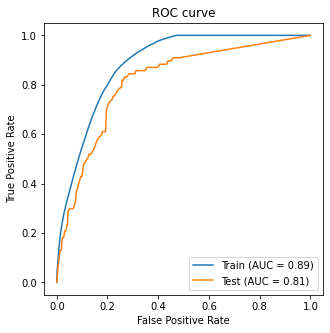

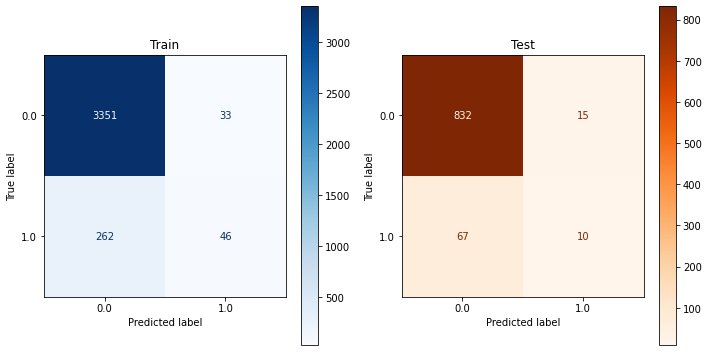

Train Precision 0.582
Train Recall    0.149

Test Precision  0.400
Test Recall     0.130


In [9]:
Model_Eval(rf_clf,X_train,X_test,y_train,y_test)

The precision and recall scores don't look great.  For this project I need higher recall, because I don't want to miss a lot of positive WNV cases.  Here I will start aggregating the scores to in a dataframe to make it easier to decide which is the best model.  

In [10]:
scores_df = agg_score_df(scores_df,rf_clf,'RandomForest default',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,RandomForest default,0.8850976520524394,0.8149082322636041,0.5822784810126582,0.14935064935064934,0.4,0.12987012987012986


In [11]:
for i in RandomForestClassifier().get_params().keys():print(i)

bootstrap
ccp_alpha
class_weight
criterion
max_depth
max_features
max_leaf_nodes
max_samples
min_impurity_decrease
min_impurity_split
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
n_estimators
n_jobs
oob_score
random_state
verbose
warm_start


In [12]:
### define grid parameters and fit model

params={'n_estimators':[50,80,100,120,150],\
       'criterion': ['gini','entropy'],\
       'max_depth':[3,5,7,9],
       'class_weight':['balanced'],\
       'random_state': [random_seed]}

rf_clf = RandomForestClassifier()

grid_rf_clf = GridSearchCV(rf_clf,param_grid=params,cv=5,n_jobs=-1,\
                           scoring=make_scorer(roc_auc_score))

grid_rf_clf.fit(X_train,y_train)

print('Best Params: ',grid_rf_clf.best_params_)
print('Best Score: ',grid_rf_clf.best_score_)

Best Params:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9, 'n_estimators': 80, 'random_state': 27}
Best Score:  0.7704287998765437


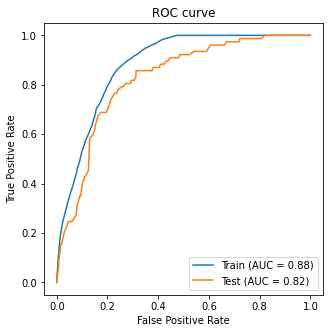

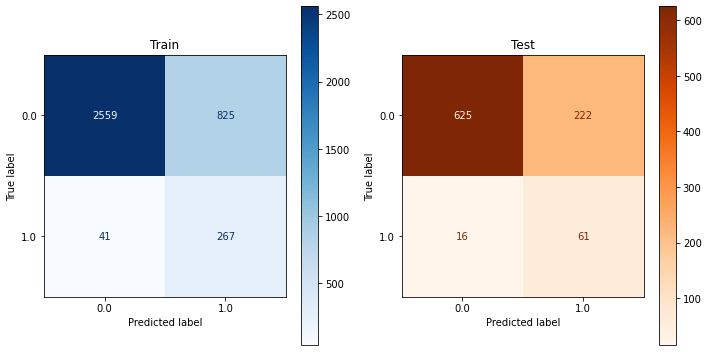

Train Precision 0.245
Train Recall    0.867

Test Precision  0.216
Test Recall     0.792


In [13]:
Model_Eval(grid_rf_clf,X_train,X_test,y_train,y_test)

That looks better but I am a little concerned about the difference in the training and testing AUC's.  The model might be a little overfit.  Maybe I should try to decrease the `max_depth` of the individual trees.  Recall has increased dramatically over the logistic regression model and the default RF.  Lets look at the precision-recall plot.

Lets look at the precision-recall plot.

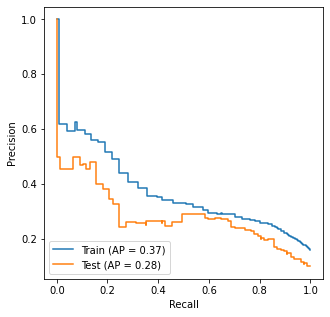

In [14]:
fig,ax = plt.subplots(figsize=(5,5))
plot_precision_recall_curve(grid_rf_clf,X_train,y_train,ax=ax,name='Train')
plot_precision_recall_curve(grid_rf_clf,X_test,y_test,ax=ax,name='Test')
plt.show()


This is not ideal.  This plot again shows the difference in performance in the training and testing set. Now I will try the same exercise above but using the PCA reduced features.  

In [15]:
scores_df = agg_score_df(scores_df,grid_rf_clf,'RandomForest tuned',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,RandomForest default,0.8850976520524394,0.8149082322636041,0.5822784810126582,0.14935064935064934,0.4,0.12987012987012986
1,RandomForest tuned,0.8806276096834608,0.8235176865637314,0.2445054945054945,0.8668831168831169,0.21554770318021202,0.7922077922077922


The tuned model is much better, but may still be a little to overfitted to the training data.
___
To mitigate overfitting I will try using the PCA transformed features. 

The PCA dataset contains the top 15 PCA components, that explain 95% of the variance in the dataset.  The PCA trained random forest has a slightly lower AUC score but a higher test recall, which suggests it is less biased than the previous model trained on the full dataset.  

# Boosted Decision trees

In [16]:
### Import gradient boost and xgboost
from sklearn.ensemble import GradientBoostingClassifier



First I will try the Gradient Boosting classifier from sklearn, starting with the default model. 

In [17]:

params={'learning_rate':[0.1]}

gb_clf = GradientBoostingClassifier(random_state=random_seed)
grid_gb_clf = GridSearchCV(gb_clf,param_grid=params,cv=5,\
                           scoring = make_scorer(roc_auc_score))
grid_gb_clf.fit(X_train,y_train)

print('Train AUC: ', roc_auc_score(y_train,grid_gb_clf.predict_proba(X_train)[:,1]))
print('Test AUC: ', roc_auc_score(y_test,grid_gb_clf.predict_proba(X_test)[:,1]))



Train AUC:  0.8790891437168032
Test AUC:  0.8300801913552799


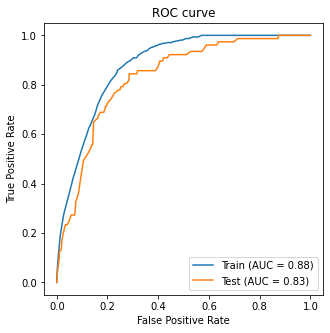

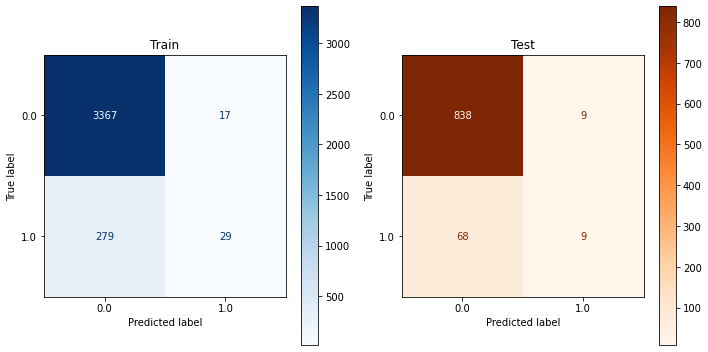

Train Precision 0.630
Train Recall    0.094

Test Precision  0.500
Test Recall     0.117


In [18]:
Model_Eval(grid_gb_clf,X_train,X_test,y_train,y_test)

In [19]:
scores_df = agg_score_df(scores_df,grid_gb_clf,'Gradient Boost default',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,RandomForest default,0.8850976520524394,0.8149082322636041,0.5822784810126582,0.14935064935064934,0.4,0.12987012987012986
1,RandomForest tuned,0.8806276096834608,0.8235176865637314,0.2445054945054945,0.8668831168831169,0.21554770318021202,0.7922077922077922
2,Gradient Boost default,0.8790891437168032,0.8300801913552799,0.6304347826086957,0.09415584415584416,0.5,0.11688311688311688


The AUC's look great, but the recall is very low.  The model needs to do have a better recall score so it doesn't miss a lot of positive WNV cases.  Now I will try to tune the model.     

In [20]:
### Gradient Boosting Classifier parameters
for i in GradientBoostingClassifier().get_params().keys():print(i)

ccp_alpha
criterion
init
learning_rate
loss
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_impurity_split
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
n_estimators
n_iter_no_change
presort
random_state
subsample
tol
validation_fraction
verbose
warm_start


In [21]:
### Gradient boosting model
params = {'max_depth':[2,3,5],\
         'learning_rate':[0.1,0.5,0.8,1],\
         'n_estimators':[20,40,80],\
          'max_features':[.5,.8,1],\
         'subsample':[.5,.8,1]}


gb_clf = GradientBoostingClassifier(random_state=random_seed)
grid_gb_clf = GridSearchCV(gb_clf,param_grid=params,cv=5,n_jobs=-1,\
                           scoring=make_scorer(roc_auc_score))

grid_gb_clf.fit(X_train,y_train)

print('Best Params: ',grid_gb_clf.best_params_)
print('Best Score: ',grid_gb_clf.best_score_)


Best Params:  {'learning_rate': 1, 'max_depth': 3, 'max_features': 0.5, 'n_estimators': 40, 'subsample': 0.5}
Best Score:  0.5841712728197251


That took much longer than the random forest, the ensemble is done in series after all.  

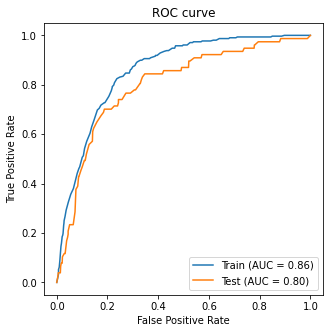

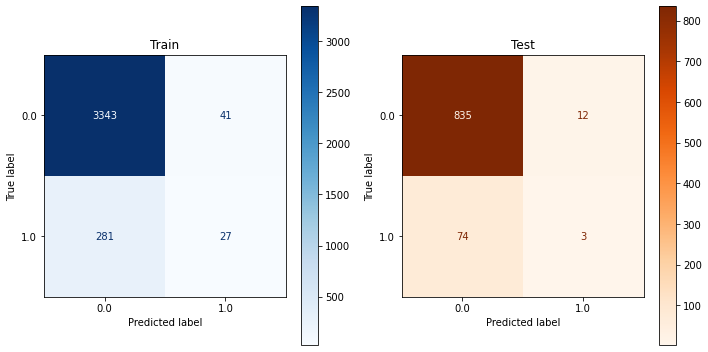

Train Precision 0.397
Train Recall    0.088

Test Precision  0.200
Test Recall     0.039


In [22]:
Model_Eval(grid_gb_clf,X_train,X_test,y_train,y_test)

In [23]:
scores_df = agg_score_df(scores_df,grid_gb_clf,'Gradient Boost tuned',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,RandomForest default,0.8850976520524394,0.8149082322636041,0.5822784810126582,0.14935064935064934,0.4,0.12987012987012986
1,RandomForest tuned,0.8806276096834608,0.8235176865637314,0.2445054945054945,0.8668831168831169,0.21554770318021202,0.7922077922077922
2,Gradient Boost default,0.8790891437168032,0.8300801913552799,0.6304347826086957,0.09415584415584416,0.5,0.11688311688311688
3,Gradient Boost tuned,0.8570267646065519,0.7990769561017494,0.39705882352941174,0.08766233766233766,0.2,0.03896103896103896


The AUC's are now both lower than the default model??.  The tuned model also has lower precision and recall than the default??? Why tune?


The tuned Gradient Boosting model scores lower than the tuned Random Forest model.  


Now I will prefrom the same modeling task but using the PCA transformed features. 

Using the PCA transformed dataset produced an even more biased and overfit model.

# Ask Rahul about tuning the GB model

## XG Boost

Now I will try an XG Boost model.  

In [24]:
import xgboost

In [25]:
### try XG Boost using default parameters

### Transform to dmatrix (I forget why...)
data_dmatrix = xgboost.DMatrix(data=X_train,label=y_train)

### Set basic parameters, No tuning yet!!
params = {'objective':'binary:logistic','eval_metric':'auc'}



cv_result = xgboost.cv(dtrain=data_dmatrix, params=params,\
                       nfold=5,as_pandas=True)

print('Train AUC: ',cv_result['train-auc-mean'].iloc[-1])
print('Test AUC: ',cv_result['test-auc-mean'].iloc[-1])


#print('Best Params: ',grid_xgb.best_params_)


Train AUC:  0.8857098000000001
Test AUC:  0.8298304


In [26]:
params = {'objective':['binary:logistic'],'eval_metric':['auc']}
xgb = xgboost.XGBClassifier()
grid_xgb = GridSearchCV(xgb,param_grid=params,cv=5)
grid_xgb.fit(X_train,y_train)

print('Train AUC: ',roc_auc_score(y_train,grid_xgb.predict_proba(X_train)[:,1]))
print('Test AUC: ',roc_auc_score(y_test,grid_xgb.predict_proba(X_test)[:,1]))


C:\Users\blain\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Train AUC:  0.885339431549538
Test AUC:  0.8292982106441373


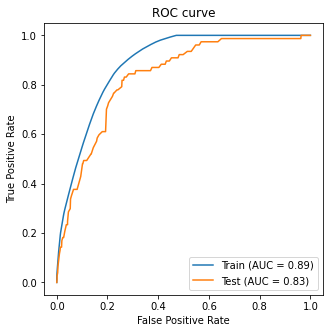

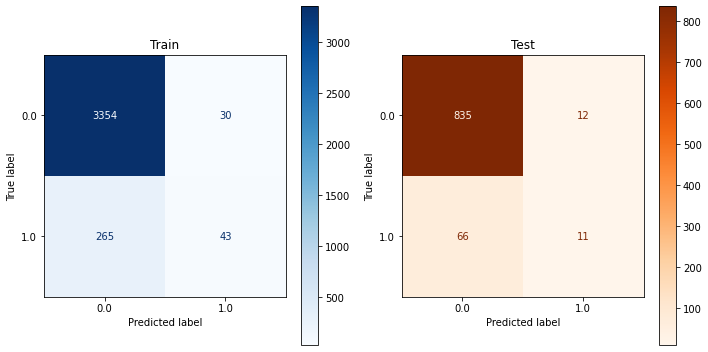

Train Precision 0.589
Train Recall    0.140

Test Precision  0.478
Test Recall     0.143


In [27]:
Model_Eval(grid_xgb,X_train,X_test,y_train,y_test)

In [28]:
scores_df = agg_score_df(scores_df,grid_xgb,'XG Boost default',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,RandomForest default,0.8850976520524394,0.8149082322636041,0.5822784810126582,0.14935064935064934,0.4,0.12987012987012986
1,RandomForest tuned,0.8806276096834608,0.8235176865637314,0.2445054945054945,0.8668831168831169,0.21554770318021202,0.7922077922077922
2,Gradient Boost default,0.8790891437168032,0.8300801913552799,0.6304347826086957,0.09415584415584416,0.5,0.11688311688311688
3,Gradient Boost tuned,0.8570267646065519,0.7990769561017494,0.39705882352941174,0.08766233766233766,0.2,0.03896103896103896
4,XG Boost default,0.885339431549538,0.8292982106441373,0.589041095890411,0.1396103896103896,0.4782608695652174,0.14285714285714285


The default XGB model looks to has a pretty low testing recall score.  I will now attempt to tune the parameters.  


In [29]:
for i in xgboost.XGBClassifier().get_params().keys(): print(i)

objective
use_label_encoder
base_score
booster
colsample_bylevel
colsample_bynode
colsample_bytree
gamma
gpu_id
importance_type
interaction_constraints
learning_rate
max_delta_step
max_depth
min_child_weight
missing
monotone_constraints
n_estimators
n_jobs
num_parallel_tree
random_state
reg_alpha
reg_lambda
scale_pos_weight
subsample
tree_method
validate_parameters
verbosity


In [30]:
### Randomized search to prevent overfitting XG Boost

from sklearn.model_selection import RandomizedSearchCV


### Transform to dmatrix (I forget why...)
data_dmatrix = xgboost.DMatrix(data=X_train,label=y_train)

### Set parameter ranges, here there are alot so I will use randomized search
params = {'objective':['binary:logistic'],'eval_metric':['auc'],\
         'subsample':np.arange(.3,.9,.1),\
         'colsample_bytree':np.arange(.3,.9,.1),\
         'gamma':np.arange(1,11,1), 'alpha':np.arange(1,100,10),\
         'lambda':np.arange(.1,10,1),\
         'learning_rate':np.arange(.01,.9,.05),\
         'max_depth':np.arange(3,15,1)}

xgb = xgboost.XGBClassifier(use_label_encoder=False)

rand_xgb = RandomizedSearchCV(estimator = xgb,param_distributions=params,cv=5,\
                             n_iter=60,n_jobs=-1,verbose=1,\
                              scoring = make_scorer(roc_auc_score))

rand_xgb.fit(X_train,y_train)


print('Best Params: ',rand_xgb.best_params_)
print('Best Score: ',rand_xgb.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.2s finished


Best Params:  {'subsample': 0.4, 'objective': 'binary:logistic', 'max_depth': 10, 'learning_rate': 0.51, 'lambda': 3.1, 'gamma': 3, 'eval_metric': 'auc', 'colsample_bytree': 0.4, 'alpha': 1}
Best Score:  0.5311419411588039


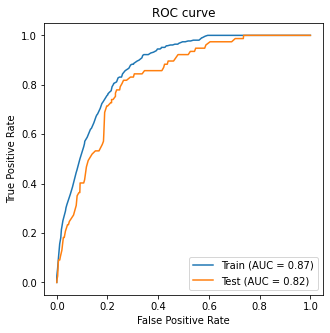

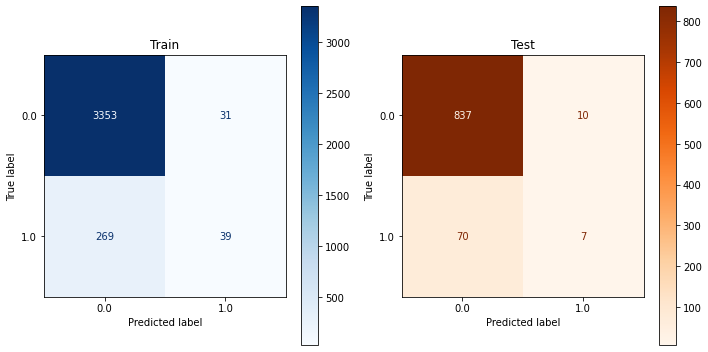

Train Precision 0.557
Train Recall    0.127

Test Precision  0.412
Test Recall     0.091


In [31]:
Model_Eval(rand_xgb,X_train,X_test,y_train,y_test)

In [32]:
scores_df = agg_score_df(scores_df,rand_xgb,'XG Boost tuned',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
1,RandomForest tuned,0.8806276096834608,0.8235176865637314,0.2445054945054945,0.8668831168831169,0.21554770318021202,0.7922077922077922
2,Gradient Boost default,0.8790891437168032,0.8300801913552799,0.6304347826086957,0.09415584415584416,0.5,0.11688311688311688
3,Gradient Boost tuned,0.8570267646065519,0.7990769561017494,0.39705882352941174,0.08766233766233766,0.2,0.03896103896103896
4,XG Boost default,0.885339431549538,0.8292982106441373,0.589041095890411,0.1396103896103896,0.4782608695652174,0.14285714285714285
5,XG Boost tuned,0.8677067982254152,0.8209110841932565,0.5571428571428572,0.1266233766233766,0.4117647058823529,0.09090909090909091


The AUC's are lower and the test precision and recall are lower as well.  What is going on?
___
Now I will try the XGBoost model with the PCA transformed features. Maybe reducing the features will help overfitting.

This model looks pretty good.  It appears to not be overfit as the training and testing precision and recall are very similar.  The PCA trained XG Boost model has a higher test precision and recall than the previous 2 models.  However, the testing AUC curve is one of the lowest I have seen so far.  

# Support Vector Machine

In [33]:
from sklearn.svm import SVC

In [34]:
### try default Support vector classifier

params={'C':[1],'class_weight':['balanced']}
### without balanced class weights the model only predicts negatives

svc = SVC(random_state=random_seed,probability=True)

grid_svc = GridSearchCV(svc,param_grid=params,cv=5,n_jobs=-1,\
                       scoring = make_scorer(roc_auc_score))

grid_svc.fit(X_train,y_train)

print('Best Params: ',grid_svc.best_params_)
print('Best Score; ',grid_svc.best_score_)

Best Params:  {'C': 1, 'class_weight': 'balanced'}
Best Score;  0.7529218083689805


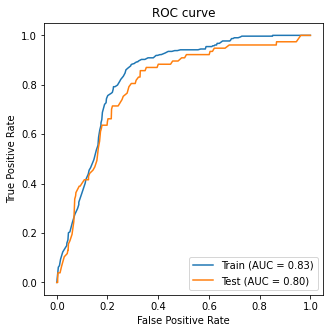

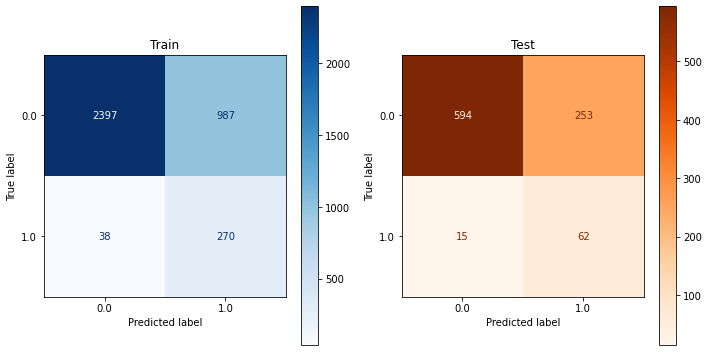

Train Precision 0.215
Train Recall    0.877

Test Precision  0.197
Test Recall     0.805


In [35]:
Model_Eval(grid_svc,X_train,X_test,y_train,y_test)

In [36]:
scores_df = agg_score_df(scores_df,grid_svc,'SVC default',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
2,Gradient Boost default,0.8790891437168032,0.8300801913552799,0.6304347826086957,0.09415584415584416,0.5,0.11688311688311688
3,Gradient Boost tuned,0.8570267646065519,0.7990769561017494,0.39705882352941174,0.08766233766233766,0.2,0.03896103896103896
4,XG Boost default,0.885339431549538,0.8292982106441373,0.589041095890411,0.1396103896103896,0.4782608695652174,0.14285714285714285
5,XG Boost tuned,0.8677067982254152,0.8209110841932565,0.5571428571428572,0.1266233766233766,0.4117647058823529,0.09090909090909091
6,SVC default,0.8305907670934267,0.796485686686395,0.21479713603818615,0.8766233766233766,0.19682539682539682,0.8051948051948052


Wow that looks pretty great.  The AUC values are above .8 with only a small difference between them.  The recall's are very high, and the model has low bias. Now I will try to improve the result with hyper-parameter tuning. 

In [37]:
### try tuning the SVC

params={'C':[1,1.5,2,4], 'kernel':['rbf','linear'],\
        'gamma':['scale','auto'], 'class_weight':['balanced']}

svc = SVC(random_state=random_seed,probability=True)

grid_svc = GridSearchCV(svc,param_grid=params,cv=5,n_jobs=-1,\
                        scoring=make_scorer(roc_auc_score))

grid_svc.fit(X_train,y_train)

print('Best Params: ',grid_svc.best_params_)
print('Best Score; ',grid_svc.best_score_)

Best Params:  {'C': 2, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best Score;  0.7606735393517606


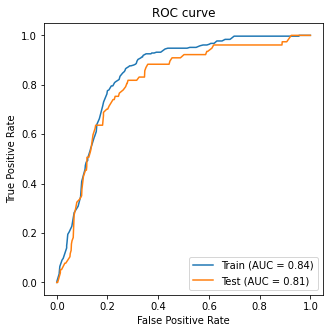

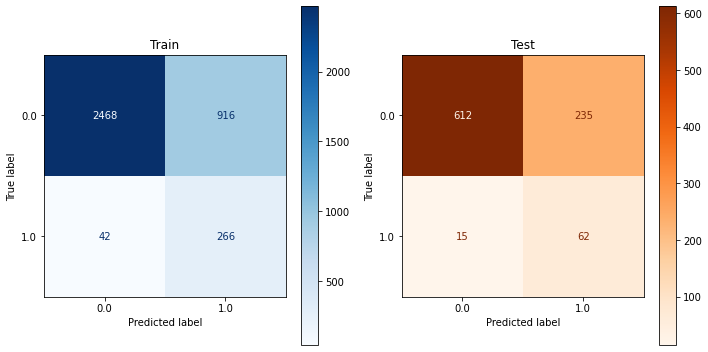

Train Precision 0.225
Train Recall    0.864

Test Precision  0.209
Test Recall     0.805


In [38]:
Model_Eval(grid_svc,X_train,X_test,y_train,y_test)

In [39]:
scores_df = agg_score_df(scores_df,grid_svc,'SVC tuned',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
3,Gradient Boost tuned,0.8570267646065519,0.7990769561017494,0.39705882352941174,0.08766233766233766,0.2,0.03896103896103896
4,XG Boost default,0.885339431549538,0.8292982106441373,0.589041095890411,0.1396103896103896,0.4782608695652174,0.14285714285714285
5,XG Boost tuned,0.8677067982254152,0.8209110841932565,0.5571428571428572,0.1266233766233766,0.4117647058823529,0.09090909090909091
6,SVC default,0.8305907670934267,0.796485686686395,0.21479713603818615,0.8766233766233766,0.19682539682539682,0.8051948051948052
7,SVC tuned,0.8412760776457585,0.8065287722902835,0.22504230118443316,0.8636363636363636,0.20875420875420875,0.8051948051948052


The model Roc plots are very similar to the default, but the grid search found `C`= 2 to produce a better result. The SVC model appears to generalize well to the testing data to the training data and the AUC is high with much higher recall.

Performance of the PCA trained model is nearly identical to the previous model. 

## Logistic Regression

Try tuning a logistic regression model again after some practice working with other models.  

In [40]:
from sklearn.linear_model import LogisticRegression


logr = LogisticRegression(random_state=random_seed,n_jobs=-1)

params = {'C':[.01,.1,.5,1,1.5,5,10], 'class_weight':[None,'balanced'],\
         'penalty':['l1','l2'], 'tol':[1E-5,1E-4,1E-3],'max_iter':[200]}

grid_logr = GridSearchCV(logr,param_grid=params,cv=5,n_jobs=-1,\
                         scoring=make_scorer(roc_auc_score))

grid_logr.fit(X_train,y_train)

print('Train AUC:',roc_auc_score(y_train,grid_logr.predict_proba(X_train)[:,1]))
print('Test AUC:',roc_auc_score(y_test,grid_logr.predict_proba(X_test)[:,1]))


Train AUC: 0.7965190468514937
Test AUC: 0.7766448427605454


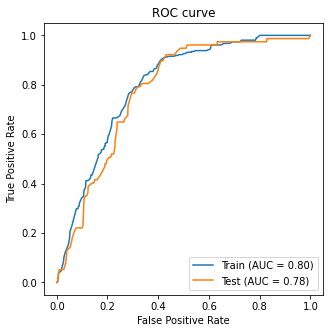

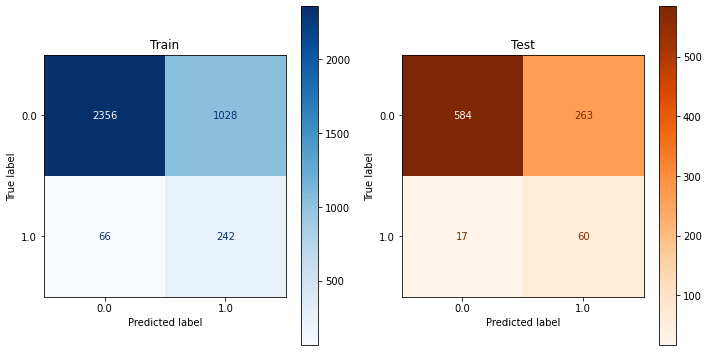

Train Precision 0.191
Train Recall    0.786

Test Precision  0.186
Test Recall     0.779


In [41]:
Model_Eval(grid_logr,X_train,X_test,y_train,y_test)

The tuned Logistic Regression Model looks pretty OK.  The ROC curves are not very steep and the AUC is a little lower than some other models.    It is clearly not overfit to the training data and has pretty good recall.

In [42]:
scores_df = agg_score_df(scores_df,grid_logr,'LogReg tuned',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
4,XG Boost default,0.885339431549538,0.8292982106441373,0.589041095890411,0.1396103896103896,0.4782608695652174,0.14285714285714285
5,XG Boost tuned,0.8677067982254152,0.8209110841932565,0.5571428571428572,0.1266233766233766,0.4117647058823529,0.09090909090909091
6,SVC default,0.8305907670934267,0.796485686686395,0.21479713603818615,0.8766233766233766,0.19682539682539682,0.8051948051948052
7,SVC tuned,0.8412760776457585,0.8065287722902835,0.22504230118443316,0.8636363636363636,0.20875420875420875,0.8051948051948052
8,LogReg tuned,0.7965190468514937,0.7766448427605454,0.19055118110236222,0.7857142857142857,0.18575851393188855,0.7792207792207793


The PCA trained model looks pretty good as well but loses a bit of predictive power compared to the previous logistic regression model. 

# Evaluate performance of all models and the choose best model

In [43]:
### Sort and change column types to numeric

for c in scores_df.columns:
    if c =='Model': continue
    scores_df[c] = pd.to_numeric(scores_df[c])
scores_df = scores_df.sort_values(by='Test_AUC',ascending=False)

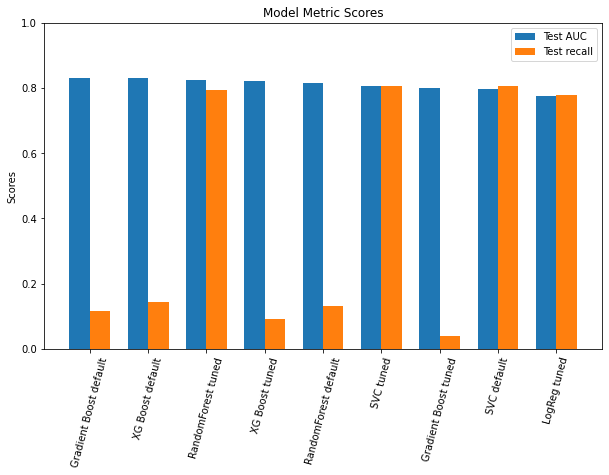

In [44]:
### Bar plot of Test AUC and Test Recall

ind = np.arange(scores_df.shape[0])
width = .35

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(ind-width/2,scores_df.Test_AUC,width,label='Test AUC')
ax.bar(ind+width/2,scores_df.Test_recal,width,label='Test recall')

ax.set_ylabel('Scores')

ax.set_ylim(0,1)

ax.set_xticks(ind)
ax.set_xticklabels(scores_df.Model,rotation=75)

ax.set_title('Model Metric Scores')
ax.legend()

plt.show()



After looking at the above plot I will select the tuned RF model.  I will use the `shap` library to inspect the tuned Random Forest classifier. 

In [18]:
### Recreate best model, Random Forest Classifier
### RF Best Params  {'class_weight': 'balanced',
### 'criterion': 'gini', 'max_depth': 9, 'n_estimators': 80,
### 'random_state': 27}
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, recall_score

rf_clf = RandomForestClassifier(class_weight='balanced',criterion='gini',\
                            max_depth=9,n_estimators=80,random_state=random_seed)
rf_clf.fit(X_train,y_train)

print('Train AUC: ',roc_auc_score(y_train,rf_clf.predict_proba(X_train)[:,1]))
print('Train Recall: ', recall_score(y_train,rf_clf.predict(X_train)))

Train AUC:  0.8806276096834608
Train Recall:  0.8668831168831169


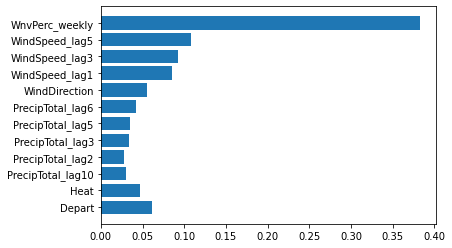

In [19]:
X_cols = list(pd.read_csv('X_train.csv',index_col=0).columns)
X_cols
#rf_clf.feature_importances_
plt.barh(X_cols,rf_clf.feature_importances_)
plt.show()

In [8]:
import shap

In [26]:
explainer = shap.TreeExplainer(rf_clf)
shap_vals = np.array(explainer.shap_values(X_train))
print(shap_vals.shape)

(2, 3692, 12)


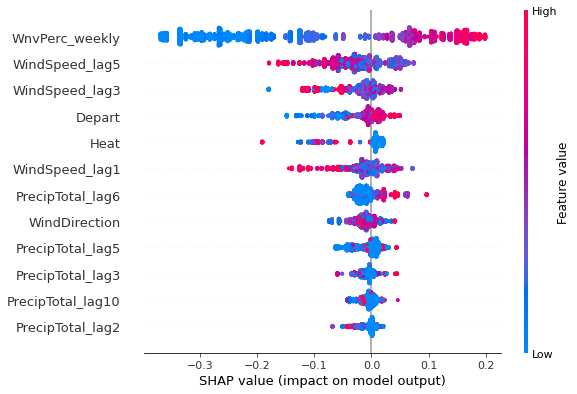

In [33]:
shap.summary_plot(shap_vals[1],pd.read_csv('X_train.csv',index_col=0))

It looks like the model output is predominantly influenced by the historical percent of WNV cases by week of the year. A high value has a positive impact on the probability for a positive case.  

Wind speed during the previous days are of secondary importance.  High values of wind speed translates to a lower probability of a positive case.   

Depart (temperature depart from normal) also has a significant impact on the model.  A high Depart value has a positive impact on the probability of positive case.  

The lagged precipitation features don't have an obvious effect on the model from this plot, except for the 6 day lag.  That feature clearly shows an increase in case probability with higher values.  

Now I will concatenate the dataset and train the Random Forest Model on all of the data so it is ready for deployment.  

In [34]:
### Concatenate the train and test sets into one large training set 
X = pd.concat([pd.DataFrame(X_train),pd.DataFrame(X_test)]).to_numpy()
y = pd.concat([pd.Series(y_train),pd.Series(y_test)]).to_numpy()

In [35]:
### Train the model with all of the data,
### and with the parameters in the tuned model above
### RF Best Params  {'class_weight': 'balanced',
### 'criterion': 'gini', 'max_depth': 9, 'n_estimators': 80,
### 'random_state': 27}

rf_clf = RandomForestClassifier(class_weight='balanced',criterion='gini',\
                            max_depth=9,n_estimators=80,random_state=random_seed)
rf_clf.fit(X,y)

print('Train AUC: ',roc_auc_score(y,rf_clf.predict_proba(X)[:,1]))
print('Train Recall: ', recall_score(y,rf_clf.predict(X)))

Train AUC:  0.8772701182060672
Train Recall:  0.8649350649350649


Looks good.  Now I have a support vector classifier tuned using cross validation and tested on a hold out set that has now been trained on all of the available data and is ready for deployment.  
___
Now I will 'pickle' the model and save it. 

In [37]:
import pickle
with open('RF_final_classifier.pkl','wb') as fid:
    pickle.dump(rf_clf,fid)